In [1]:
# execute to install Python dependencies
# %%capture
# !pip install sf-hamilton[visualization] ipywidgets

# Hamilton caching tutorial
In Hamilton, **caching** broadly refers to "reusing results from previous executions to skip redundant computation". If you change code or pass new data, it will automatically determine which results can be reused and which nodes need to be re-executed. This improves execution speed and reduces resource usage (computation, API credits, etc.).

**Table of contents**
1. [Basics](#basics)
    1. [Understanding the `cache_key`](#understanding-the-cache_key)
2. [Adding a node](#adding-a-node)
3. [Changing inputs](#changing-inputs)
4. [Changing code](#changing-code)
5. [Changing external data](#changing-external-data)
    1. [`.with_cache()` to specify caching behavior](#with_cache-to-specify-caching-behavior)
    2. [`@cache` to specify caching behavior](#cache-to-specify-caching-behavior)
6. [Debugging with `cache_key`](#debugging-with-cache_key)


> NOTE. This notebook is on the longer side. We highly suggest using the navigation bar to help.

Throughout this tutorial, we'll be using the Hamilton notebook extension to define dataflows directly in the notebook ([see tutorial](https://github.com/DAGWorks-Inc/hamilton/blob/main/examples/jupyter_notebook_magic/example.ipynb)).


In [2]:
from hamilton import driver

# load the notebook extension
%reload_ext hamilton.plugins.jupyter_magic

/home/tjean/projects/dagworks/hamilton/.venv/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


We import the `logging` module and get the logger from `hamilton.caching`. With the level set to ``INFO``, we'll see ``GET_RESULT`` and ``EXECUTE_NODE`` cache events as they happen.

In [3]:
import logging

logger = logging.getLogger("hamilton.caching")
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

The next cell deletes the cached data to ensure this notebook can be run from top to bottom without any issues.

In [4]:
import shutil

shutil.rmtree("/.hamilton_cache", ignore_errors=True)

## Basics

Throughout this notebook, we'll use the same simple dataflow that processes transactions in various locations and currencies.

We use the cell magic `%%cell_to_module` from the Hamilton notebook extension. It will convert the content of the cell into a Python module that can be loaded by Hamilton. The `--display` flag allows to visualize the dataflow.

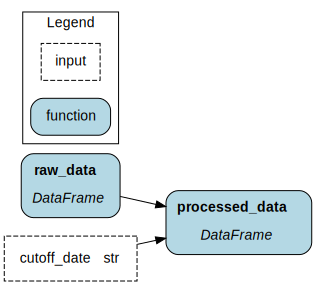

In [5]:
%%cell_to_module basics_module --display
import pandas as pd

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56],
    "country": ["USA", "USA", "USA", "Canada", "Canada"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD"],
}

def raw_data() -> pd.DataFrame:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    return pd.DataFrame(DATA)

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.73
    return df

Then, we build the ``Driver`` with caching enabled and execute the dataflow.

In [6]:
basics_dr = driver.Builder().with_modules(basics_module).with_cache().build()

basics_results_1 = basics_dr.execute(["processed_data"], inputs={"cutoff_date": "2024-09-01"})
print()
print(basics_results_1["processed_data"].head())

raw_data::adapter::execute_node
processed_data::adapter::execute_node



        cities        date  amount country currency  amound_in_usd
0     New York  2024-09-13  478.23     USA      USD       478.2300
1  Los Angeles  2024-09-12  251.67     USA      USD       251.6700
2      Chicago  2024-09-11  989.34     USA      USD       989.3400
3     Montréal  2024-09-11  742.14  Canada      CAD       541.7622
4    Vancouver  2024-09-09  584.56  Canada      CAD       426.7288


We can view what values were retrieved from the cache using `dr.cache.view_run()`. Since this was the first execution, nothing is retrieved.

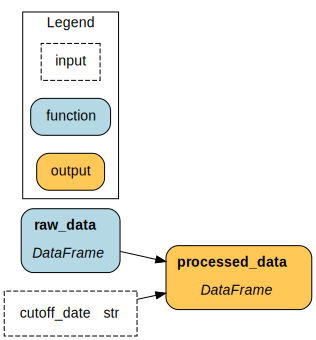

In [7]:
basics_dr.cache.view_run()

On the second execution, `processed_data` is retrieved from cache as reported in the logs and highlighted in the visualization

raw_data::result_store::get_result::hit
processed_data::result_store::get_result::hit



        cities        date  amount country currency  amound_in_usd
0     New York  2024-09-13  478.23     USA      USD       478.2300
1  Los Angeles  2024-09-12  251.67     USA      USD       251.6700
2      Chicago  2024-09-11  989.34     USA      USD       989.3400
3     Montréal  2024-09-11  742.14  Canada      CAD       541.7622
4    Vancouver  2024-09-09  584.56  Canada      CAD       426.7288



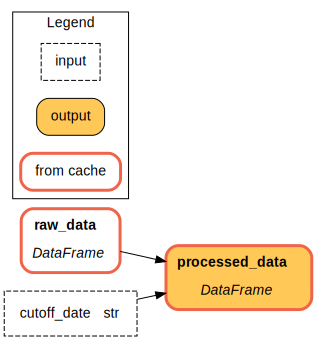

In [8]:
basics_results_2 = basics_dr.execute(["processed_data"], inputs={"cutoff_date": "2024-09-01"})
print()
print(basics_results_2["processed_data"].head())
print()
basics_dr.cache.view_run()

### Understanding the `cache_key`

The Hamilton cache stores results using a `cache_key`. It is composed of the node's name (`node_name`), the code that defines it (`code_version`), and its data inputs (`data_version` of its dependencies).

For example, the cache keys for the previous cells are:

```json
{
    "node_name": "raw_data",
    "code_version": "9d727859b9fd883247c3379d4d25a35af4a56df9d9fde20c75c6375dde631c68",
    "dependencies_data_versions": {}  // it has no dependencies
}
{
    "node_name": "processed_data",
    "code_version": "c9e3377d6c5044944bd89eeb7073c730ee8707627c39906b4156c6411f056f00",
    "dependencies_data_versions": {
        "cutoff_date": "WkGjJythLWYAIj2Qr8T_ug==",  // input value
        "raw_data": "t-BDcMLikFSNdn4piUKy1mBcKPoEsnsYjUNzWg=="  // raw_data's result
    }
}
```

Results could be successfully retrieved because nodes in the first execution and second execution shared the same `cache_key`.

The `cache_key` objects are internal and you won't have to interact with them directly. However, keep that concept in mind throughout this tutorial. Towards the end, we show how to manually handle the `cache_key` for debugging.

## Adding a node

Let's say you're iteratively developing your dataflow and you add a new node. Here, we copy the previous module into a new module named `adding_node_module` and define the node `amount_per_country`.

> In practice, you would edit the cell directly, but this makes the notebook easier to read and maintain

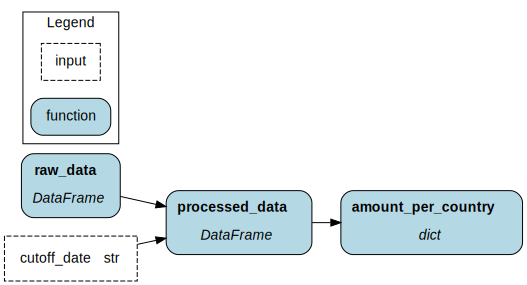

In [9]:
%%cell_to_module adding_node_module --display
import pandas as pd

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56],
    "country": ["USA", "USA", "USA", "Canada", "Canada"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD"],
}

def raw_data() -> pd.DataFrame:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    return pd.DataFrame(DATA)

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.73
    return df

def amount_per_country(processed_data: pd.DataFrame) -> dict:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum()

We build a new `Driver` with `adding_node_module` and execute the dataflow. You'll notice that `raw_data` and `processed_data` are retrieved and only `amount_per_country` is executed.

raw_data::result_store::get_result::hit
processed_data::result_store::get_result::hit
amount_per_country::adapter::execute_node



country
Canada     968.491
USA       1719.240
Name: amound_in_usd, dtype: float64



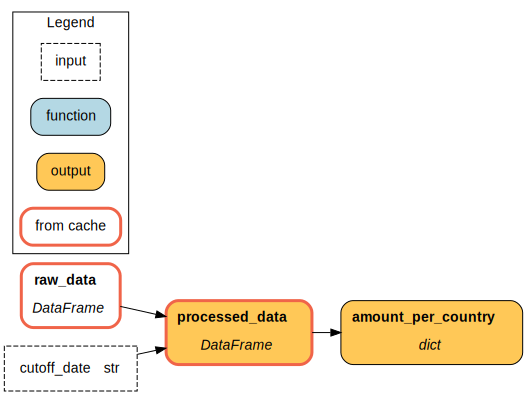

In [10]:
adding_node_dr = driver.Builder().with_modules(adding_node_module).with_cache().build()

adding_node_results = adding_node_dr.execute(
    ["processed_data", "amount_per_country"],
    inputs={"cutoff_date": "2024-09-01"}
)
print()
print(adding_node_results["amount_per_country"].head())
print()
adding_node_dr.cache.view_run()

Even though this is the first execution of `adding_node_dr` and the module `adding_node_module`, the cache contains results for `raw_data` and `processed_data`. We're able to retrieve values because they have the same cache keys (code version and dependencies data versions).

This means you can reuse cached results across dataflows. This is particularly useful with training and inference machine learning pipelines.

## Changing inputs

We reuse the same dataflow `adding_node_module`, but change the input `cutoff_date` from
`"2024-09-01"` to `"2024-09-11"`. 


This new input forces `processed_data` to be re-executed. This produces a new result for `processed_data`, which cascades and also forced `amount_per_country` to be re-executed.

raw_data::result_store::get_result::hit
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node



country
USA    729.9
Name: amound_in_usd, dtype: float64



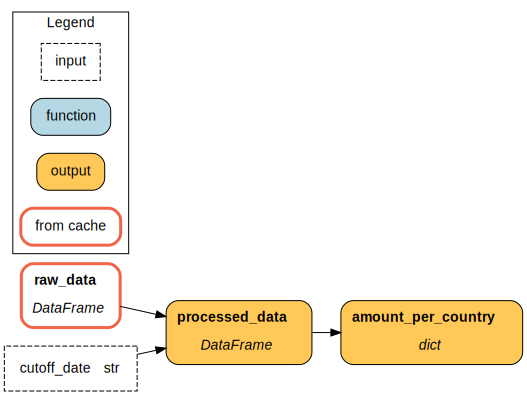

In [11]:
changing_inputs_dr = driver.Builder().with_modules(adding_node_module).with_cache().build()

changing_inputs_results_1 = changing_inputs_dr.execute(
    ["processed_data", "amount_per_country"],
    inputs={"cutoff_date": "2024-09-11"}
)
print()
print(changing_inputs_results_1["amount_per_country"].head())
print()
changing_inputs_dr.cache.view_run()

Now, we execute with the `cutoff_date` value `"2024-09-05"`, which forces `processed_data` to be executed.

raw_data::result_store::get_result::hit
processed_data::adapter::execute_node
amount_per_country::result_store::get_result::hit



country
Canada     968.491
USA       1719.240
Name: amound_in_usd, dtype: float64



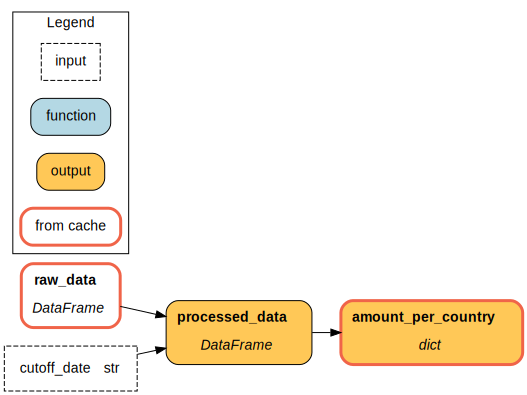

In [12]:
changing_inputs_results_2 = changing_inputs_dr.execute(
    ["processed_data", "amount_per_country"],
    inputs={"cutoff_date": "2024-09-05"}
)
print()
print(changing_inputs_results_2["amount_per_country"].head())
print()
changing_inputs_dr.cache.view_run()

Notice that the cache could still retrieve `amount_per_country`. This is because `processed_data` return a value that had been cached previously (in the `Adding a node` section).

In concrete terms, filtering rows by the date `"2024-09-05"` or `"2024-09-01"` includes the same rows and produces the same dataframe.

In [13]:
print(adding_node_results["processed_data"])
print()
print(changing_inputs_results_2["processed_data"])

        cities        date  amount country currency  amound_in_usd
0     New York  2024-09-13  478.23     USA      USD       478.2300
1  Los Angeles  2024-09-12  251.67     USA      USD       251.6700
2      Chicago  2024-09-11  989.34     USA      USD       989.3400
3     Montréal  2024-09-11  742.14  Canada      CAD       541.7622
4    Vancouver  2024-09-09  584.56  Canada      CAD       426.7288

        cities        date  amount country currency  amound_in_usd
0     New York  2024-09-13  478.23     USA      USD       478.2300
1  Los Angeles  2024-09-12  251.67     USA      USD       251.6700
2      Chicago  2024-09-11  989.34     USA      USD       989.3400
3     Montréal  2024-09-11  742.14  Canada      CAD       541.7622
4    Vancouver  2024-09-09  584.56  Canada      CAD       426.7288


## Changing code
As you develop your dataflow, you will need to edit upstream nodes. Caching will automatically detect code changes and determine which node needs to be re-executed. In `processed_data()`, we'll change the conversation rate from `0.73` to `0.71`.

> NOTE. changes to docstrings and comments `#` are ignored when versioning a node.

In [14]:
%%cell_to_module changing_code_module
import pandas as pd

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56],
    "country": ["USA", "USA", "USA", "Canada", "Canada"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD"],
}

def raw_data() -> pd.DataFrame:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    return pd.DataFrame(DATA)

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  # <- VALUE CHANGED FROM module_2
    return df

def amount_per_country(processed_data: pd.DataFrame) -> dict:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum()

We need to execute `processed_data` because the code change created a new `cache_key` and led to a cache miss. Then, `processed_data` returns a previously unseen value, forcing `amount_per_country` to also be re-executed

raw_data::result_store::get_result::hit
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node



country
Canada     941.957
USA       1719.240
Name: amound_in_usd, dtype: float64



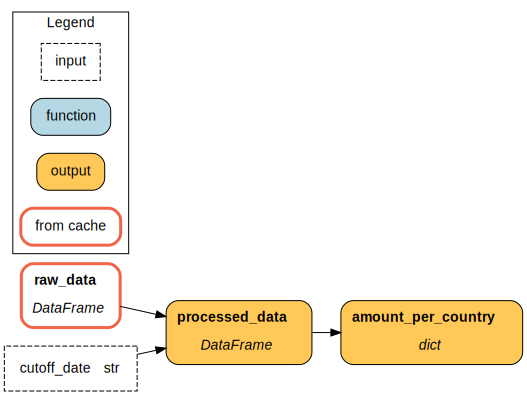

In [15]:
changing_code_dr_1 = driver.Builder().with_modules(changing_code_module).with_cache().build()

changing_code_results_1 = changing_code_dr_1.execute(
    ["processed_data", "amount_per_country"],
    inputs={"cutoff_date": "2024-09-01"}
)
print()
print(changing_code_results_1["amount_per_country"].head())
print()
changing_code_dr_1.cache.view_run()

We make another code change to `processed_data` to accomodate currency conversion for Brazil and Mexico.

In [16]:
%%cell_to_module changing_code_module_2
import pandas as pd

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56],
    "country": ["USA", "USA", "USA", "Canada", "Canada"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD"],
}

def raw_data() -> pd.DataFrame:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    return pd.DataFrame(DATA)

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18  # <- LINE ADDED
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05  # <- LINE ADDED
    return df

def amount_per_country(processed_data: pd.DataFrame) -> dict:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum()

Again, the code change forces `processed_data` to be executed.

raw_data::result_store::get_result::hit
processed_data::adapter::execute_node
amount_per_country::result_store::get_result::hit



country
Canada     941.957
USA       1719.240
Name: amound_in_usd, dtype: float64



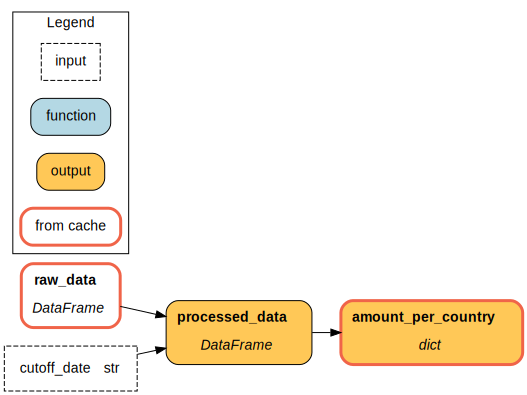

In [17]:
changing_code_dr_2 = driver.Builder().with_modules(changing_code_module_2).with_cache().build()

changing_code_results_2 = changing_code_dr_2.execute(["processed_data","amount_per_country"], inputs={"cutoff_date": "2024-09-01"})
print()
print(changing_code_results_2["amount_per_country"].head())
print()
changing_code_dr_2.cache.view_run()

However, `amount_per_country` can be retrieved because `processed_data` returned a previously seen value.

In concrete terms, adding code to process currency from Brazil and Mexico didn't change the `processed_data` result because it only includes data from the USA and Canada.

> NOTE. This is similar to what happened at the end of the section **Changing inputs**.

In [18]:
print(changing_code_results_1["processed_data"])
print()
print(changing_code_results_2["processed_data"])

        cities        date  amount country currency  amound_in_usd
0     New York  2024-09-13  478.23     USA      USD       478.2300
1  Los Angeles  2024-09-12  251.67     USA      USD       251.6700
2      Chicago  2024-09-11  989.34     USA      USD       989.3400
3     Montréal  2024-09-11  742.14  Canada      CAD       526.9194
4    Vancouver  2024-09-09  584.56  Canada      CAD       415.0376

        cities        date  amount country currency  amound_in_usd
0     New York  2024-09-13  478.23     USA      USD       478.2300
1  Los Angeles  2024-09-12  251.67     USA      USD       251.6700
2      Chicago  2024-09-11  989.34     USA      USD       989.3400
3     Montréal  2024-09-11  742.14  Canada      CAD       526.9194
4    Vancouver  2024-09-09  584.56  Canada      CAD       415.0376


## Changing external data

Hamilton's caching mechanism uses the node's `code_version` and its dependencies `data_version` to determine if the node needs to be executed or the result can be retrieved from cache. By default, it assumes [idempotency](https://www.astronomer.io/docs/learn/dag-best-practices#review-idempotency) of operations.

This section covers how to handle node with external effects, such as reading or writing external data.


### Idempotency

To illustrate idempotency, let's use this minimal dataflow which has a single node that returns the current date and time:

```python
import datetime

def current_datetime() -> datetime.datetime:
    return datetime.datetime.now()
```

The first execution will execute the node and store the resulting date and time. On the second execution, the cache will read the stored result instead of re-executing. Why? Because the `code_version` is the same and the dependencies `data_version` (it has no dependencies) haven't changed.

A similar situation occurs when reading from external data, as shown here:

```python
import pandas as pd

def dataset(file_path: str) -> pd.DataFrame:
    return pd.read_csv(file_path)
```

Here, the code of `dataset()` and the value for `file_path` can stay the same, but the file itself could be updated (e.g., new rows added).

The next sections show how to always re-execute a node and ensure the latest data is used. The `DATA` constant is modified with transactions in Brazil and Mexico to simulate `raw_data` loading a new dataset.

In [19]:
%%cell_to_module changing_external_module
import pandas as pd

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver", "Houston", "Phoenix", "Mexico City", "Chihuahua City", "Rio de Janeiro"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09", "2024-09-08", "2024-09-07", "2024-09-06", "2024-09-05", "2024-09-04"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56, 321.85, 918.67, 135.22, 789.12, 432.78],
    "country": ["USA", "USA", "USA", "Canada", "Canada", "USA", "USA", "Mexico", "Mexico", "Brazil"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD", "USD", "USD", "MXN", "MXN", "BRL"],
}

def raw_data() -> pd.DataFrame:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    return pd.DataFrame(DATA)

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05
    return df

def amount_per_country(processed_data: pd.DataFrame) -> dict:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum()

At execution, we see `raw_data` being retrieved along with all downstream nodes. Also, we note that the printed results don't include Brazil nor Mexico.

raw_data::result_store::get_result::hit
processed_data::result_store::get_result::hit
amount_per_country::result_store::get_result::hit



country
Canada     941.957
USA       1719.240
Name: amound_in_usd, dtype: float64



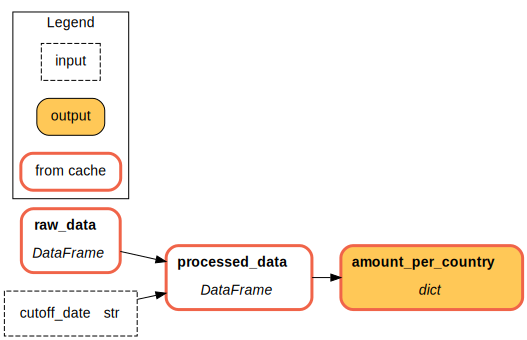

In [20]:
changing_external_dr = driver.Builder().with_modules(changing_external_module).with_cache().build()

changing_external_results = changing_external_dr.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-01"})
print()
print(changing_external_results["amount_per_country"].head())
print()
changing_external_dr.cache.view_run()

### `.with_cache()` to specify caching behavior
Here, we build a new `Driver` with the same `changing_external_module`, but we specify in `.with_cache()` to always recompute `raw_data`. 

The visualization shows that `raw_data` was executed, and because of the new data, all downstream nodes also need to be executed. The results now include Brazil and Mexico.

raw_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node



country
Brazil      77.9004
Canada     941.9570
Mexico      46.2170
USA       2959.7600
Name: amound_in_usd, dtype: float64



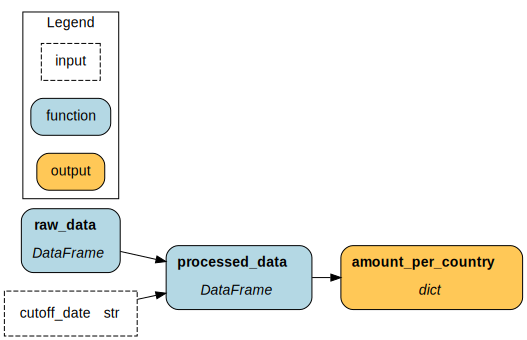

In [21]:
changing_external_with_cache_dr = driver.Builder().with_modules(changing_external_module).with_cache(recompute=["raw_data"]).build()

changing_external_with_cache_results = changing_external_with_cache_dr.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-01"})
print()
print(changing_external_with_cache_results["amount_per_country"].head())
print()
changing_external_with_cache_dr.cache.view_run()

### `@cache` to specify caching behavior
Another way to specify the `RECOMPUTE` behavior is to use the `@cache` decorator.

In [22]:
%%cell_to_module changing_external_decorator_module
import pandas as pd
from hamilton.function_modifiers import cache

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver", "Houston", "Phoenix", "Mexico City", "Chihuahua City", "Rio de Janeiro"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09", "2024-09-08", "2024-09-07", "2024-09-06", "2024-09-05", "2024-09-04"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56, 321.85, 918.67, 135.22, 789.12, 432.78],
    "country": ["USA", "USA", "USA", "Canada", "Canada", "USA", "USA", "Mexico", "Mexico", "Brazil"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD", "USD", "USD", "MXN", "MXN", "BRL"],
}

@cache(behavior="recompute")
def raw_data() -> pd.DataFrame:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    return pd.DataFrame(DATA)

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05
    return df

def amount_per_country(processed_data: pd.DataFrame) -> dict:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum()

We build a new `Driver` with `changing_external_cache_decorator_module`, which includes the `@cache` decorator. Note that we don't specify anything in `.with_cache()`.

raw_data::adapter::execute_node
processed_data::result_store::get_result::hit
amount_per_country::result_store::get_result::hit



country
Brazil      77.9004
Canada     941.9570
Mexico      46.2170
USA       2959.7600
Name: amound_in_usd, dtype: float64



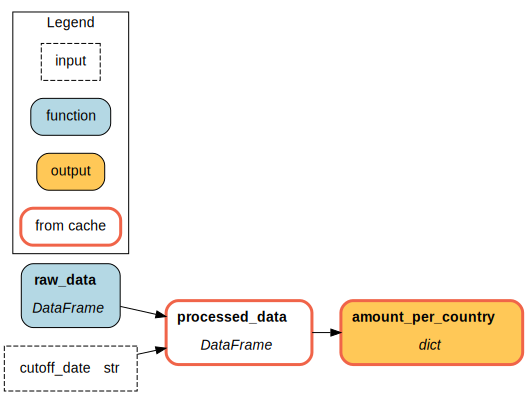

In [23]:
changing_external_decorator_dr = (
    driver.Builder()
    .with_modules(changing_external_decorator_module)
    .with_cache()
    .build()
)

changing_external_decorator_results = changing_external_decorator_dr.execute(
    ["amount_per_country"],
    inputs={"cutoff_date": "2024-09-01"}
)
print()
print(changing_external_decorator_results["amount_per_country"].head())
print()
changing_external_decorator_dr.cache.view_run()

We see that `raw_data` was re-executed. Then, `processed_data` and `amount_per_country` can be retrieved because they were produced just before by the `changing_external_with_cache_dr`

### Why use `.with_cache()` or `@cache`?

Specifying the caching behavior via `.with_cache()` or `@cache` is entirely equivalent. There are benefits to either approach:

- `@cache`: specify behavior at the dataflow-level. The behavior is tied to the node and will be picked up by all `Driver` loading the module. This can prevent errors or unexpected behaviors for users of that dataflow.

- `.with_cache()`: specify behavior at the `Driver`-level. Gives the flexiblity to change the behavior without modifying the dataflow code and committing changes. You might be ok with `DEFAULT` during development, but want to ensure `RECOMPUTE` in production.

Importantly, the behavior specified in `.with_cache(...)` overrides whatever is in `@cache` because it is closer to execution. For example, having `.with_cache(default=["raw_data"])` `@cache(behavior="recompute")` would force `DEFAULT` behavior.

> ⛔ **Important**: Using the `@cache` decorator alone doesn't enable caching; adding `.with_cache()` to the `Builder` does. The decorator is only a mean to specify special behaviors for a node.


### Always recompute materializers
An alternative to specifying caching behavior via `.with_cache()` or `@cache` is to use data loaders. In Hamilton, data loaders (and savers) are meant to connect your dataflow to external data (files, databases, etc.) and exist in several flavors. Given their nature, caching sets their behavior to `recompute` by default (which can be overriden).

Let's rewrite the dataflow with the `@dataloader` decorator. Note that the function now needs to return a `tuple` of `(result, metadata)`. The tuple type annotation needs to specify that `raw_data` returns a `pd.DataFrame` as the first element.

In [24]:
%%cell_to_module cache_and_loader_module
import pandas as pd
from hamilton.function_modifiers import dataloader

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver", "Houston", "Phoenix", "Mexico City", "Chihuahua City", "Rio de Janeiro"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09", "2024-09-08", "2024-09-07", "2024-09-06", "2024-09-05", "2024-09-04"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56, 321.85, 918.67, 135.22, 789.12, 432.78],
    "country": ["USA", "USA", "USA", "Canada", "Canada", "USA", "USA", "Mexico", "Mexico", "Brazil"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD", "USD", "USD", "MXN", "MXN", "BRL"],
}

@dataloader()
def raw_data() -> tuple[pd.DataFrame, dict]:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    data = pd.DataFrame(DATA)
    metadata = {"source": "notebook", "format": "json"}
    return data, metadata

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05
    return df

def amount_per_country(processed_data: pd.DataFrame) -> dict:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum()

The visualization now displays the "materializer" node for the data loader. When we execute the dataflow, it behaves as expected.

raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::result_store::get_result::hit
amount_per_country::result_store::get_result::hit



country
Brazil      77.9004
Canada     941.9570
Mexico      46.2170
USA       2959.7600
Name: amound_in_usd, dtype: float64



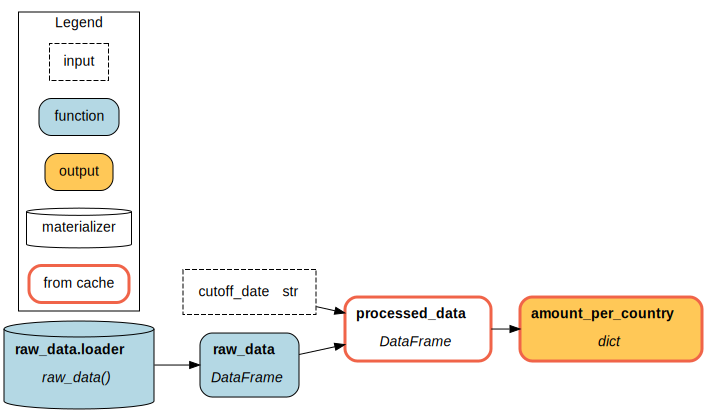

In [25]:
cache_and_loader_dr = (
    driver.Builder()
    .with_modules(cache_and_loader_module)
    .with_cache()
    .build()
)

cache_and_loader_results = cache_and_loader_dr.execute(
    ["amount_per_country"],
    inputs={"cutoff_date": "2024-09-01"}
)
print()
print(cache_and_loader_results["amount_per_country"].head())
print()
cache_and_loader_dr.cache.view_run()

### Force recompute all
By specifying `.with_cache(recompute=True)`, you are setting the behavior `RECOMPUTE` for all nodes. This forces recomputation, which is useful for producing a "cache refresh" with up-to-date values.

raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node



country
Brazil      77.9004
Canada     941.9570
Mexico      46.2170
USA       2959.7600
Name: amound_in_usd, dtype: float64



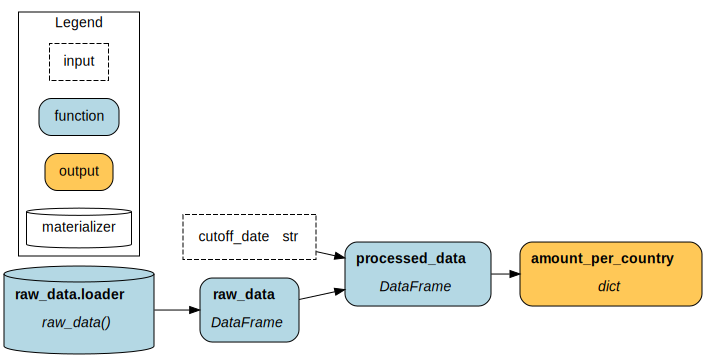

In [26]:
recompute_all_dr = (
    driver.Builder()
    .with_modules(cache_and_loader_module)
    .with_cache(recompute=True)
    .build()
)

recompute_all_results = recompute_all_dr.execute(
    ["amount_per_country"],
    inputs={"cutoff_date": "2024-09-01"}
)
print()
print(recompute_all_results["amount_per_country"].head())
print()
recompute_all_dr.cache.view_run()

We see that all nodes were recomputed.

## Changing the cache format

By default, results are stored in ``pickle`` format. It's a convenient default but [comes with caveats](https://grantjenks.com/docs/diskcache/tutorial.html#caveats). You can use the `@cache` decorator to specify another file format for storing results.

By default this includes:

- `json`
- `parquet`
- `csv`
- `excel`
- `file`
- `feather`
- `orc`

This feature uses `DataLoader` and `DataSaver` under the hood and supports all of the same formats (including your custom ones, as long as they take a `path` attribute).

> This is an area of active development. Feel free to share suggestions and feedback!

The next cell sets `processed_data` to be cached using the `parquet` format.

In [27]:
%%cell_to_module cache_format_module
import pandas as pd
from hamilton.function_modifiers import dataloader, cache

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver", "Houston", "Phoenix", "Mexico City", "Chihuahua City", "Rio de Janeiro"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09", "2024-09-08", "2024-09-07", "2024-09-06", "2024-09-05", "2024-09-04"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56, 321.85, 918.67, 135.22, 789.12, 432.78],
    "country": ["USA", "USA", "USA", "Canada", "Canada", "USA", "USA", "Mexico", "Mexico", "Brazil"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD", "USD", "USD", "MXN", "MXN", "BRL"],
}

@dataloader()
def raw_data() -> tuple[pd.DataFrame, dict]:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    data = pd.DataFrame(DATA)
    metadata = {"source": "notebook", "format": "json"}
    return data, metadata

@cache(format="parquet")
def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05
    return df

def amount_per_country(processed_data: pd.DataFrame) -> dict:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum()

When executing the dataflow, we see `raw_data` recomputed because it's a dataloader. The result for `processed_data` will be retrieved, but it will be saved again as `.parquet` this time. 

raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::result_store::get_result::hit



country
Brazil      77.9004
Canada     941.9570
Mexico      46.2170
USA       2959.7600
Name: amound_in_usd, dtype: float64



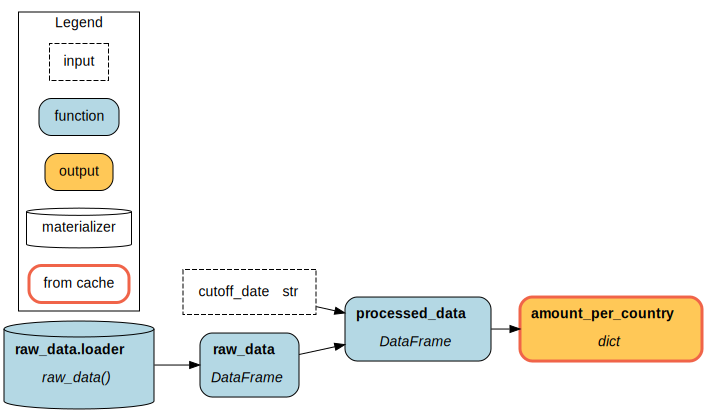

In [28]:
cache_format_dr = driver.Builder().with_modules(cache_format_module).with_cache().build()

cache_format_results = cache_format_dr.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-01"})
print()
print(cache_format_results["amount_per_country"].head())
print()
cache_format_dr.cache.view_run()

Now, under the `./.hamilton_cache`, there will be two results of the same name, one with the `.parquet` extension and one without. The one without is actually a pickeld `DataLoader` to retrieve the `.parquet` file.

You can access the path programmatically via the `result_store._path_from_data_version(...)` method.

In [29]:
data_version = cache_format_dr.cache.data_versions[cache_format_dr.cache.last_run_id]["processed_data"]
parquet_path = cache_format_dr.cache.result_store._path_from_data_version(data_version).with_suffix(".parquet")
parquet_path.exists()

True

## Introspecting the cache
The `Driver.cache` stores information about all executions over its lifetime. Previous `run_id` are available through `Driver.cache.run_ids` and can be used in tandem without other utility functions:

- Resolve the node caching behavior (e.g., "recompute")
- Access structured logs
- Visualize the cache execution

Also, `Driver.cache.last_run_id` is a shortcut to the most recent execution.

In [30]:
cache_format_dr.cache.resolve_behaviors(cache_format_dr.cache.last_run_id)

{'amount_per_country': <CachingBehavior.DEFAULT: 1>,
 'processed_data': <CachingBehavior.DEFAULT: 1>,
 'raw_data.loader': <CachingBehavior.RECOMPUTE: 2>,
 'raw_data': <CachingBehavior.RECOMPUTE: 2>,
 'cutoff_date': <CachingBehavior.DEFAULT: 1>}

In [31]:
run_logs = cache_format_dr.cache.logs(cache_format_dr.cache.last_run_id, level="debug")
for event in run_logs["processed_data"]:
    print(event)

processed_data::adapter::resolve_behavior
processed_data::adapter::set_cache_key
processed_data::adapter::get_cache_key::hit
processed_data::adapter::get_data_version::miss
processed_data::metadata_store::get_data_version::miss
processed_data::adapter::execute_node
processed_data::adapter::set_data_version
processed_data::metadata_store::set_data_version
processed_data::adapter::get_cache_key::hit
processed_data::adapter::get_data_version::hit
processed_data::result_store::set_result
processed_data::adapter::get_data_version::hit
processed_data::adapter::resolve_behavior


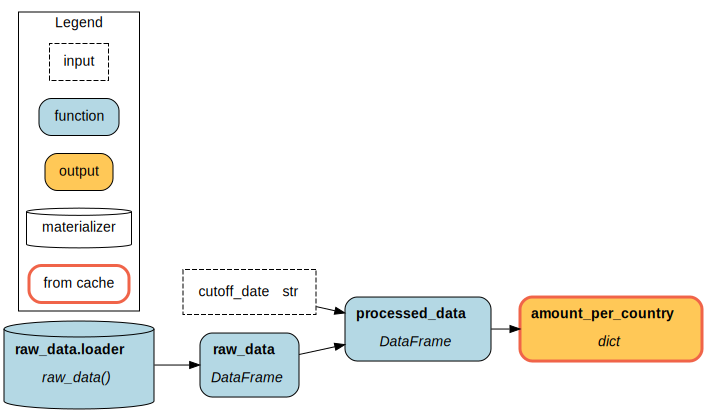

In [32]:
# for `.view_run()` passing no parameter is equivalent to the last `run_id`
cache_format_dr.cache.view_run(cache_format_dr.cache.last_run_id)

### Interactively explore runs
By using `ipywidgets` we can easily build a widget to iterate over `run_id` values and display cache information. Below, we create a `Driver` and execute it a few times to generate data then inspect it with a widget.

In [33]:
interactive_dr = driver.Builder().with_modules(cache_format_module).with_cache().build()

interactive_dr.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-01"})
interactive_dr.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-05"})
interactive_dr.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-10"})
interactive_dr.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-11"})
interactive_dr.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-13"})

raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::result_store::get_result::hit
amount_per_country::result_store::get_result::hit
raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node
raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node
raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::result_store::get_result::hit
raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node


{'amount_per_country': Series([], Name: amound_in_usd, dtype: float64)}

The following cell allows you to click-and-drag or use arrow-keys to navigate

In [34]:
from IPython.display import display
from ipywidgets import SelectionSlider, interact


@interact(run_id=SelectionSlider(options=interactive_dr.cache.run_ids))
def iterate_over_runs(run_id):
    display(interactive_dr.cache.data_versions[run_id])
    display(interactive_dr.cache.view_run(run_id=run_id))

interactive(children=(SelectionSlider(description='run_id', options=('f7b47356-3073-4e70-98bf-7bf5183b4aff', '…

## Managing storage
### Setting the cache `path`

By default, metadata and results are stored under `./.hamilton_cache`, relative to the current directory at execution time. You can also manually set the directory via `.with_cache(path=...)` to isolate or centralize cache storage between dataflows or projects.

Running the next cell will create the directory `./my_other_cache`.

In [35]:
manual_path_dr = driver.Builder().with_modules(cache_format_module).with_cache(path="./my_other_cache").build()

### Instantiating the `result_store` and `metadata_store`
If you need to store metadata and results in separate locations, you can do so by instantiating the `result_store` and `metadata_store` manually with their own configuration. In this case, setting `.with_cache(path=...)` would be ignored.

In [36]:
from hamilton.caching.stores.file import FileResultStore
from hamilton.caching.stores.sqlite import SQLiteMetadataStore

result_store = FileResultStore(path="./results")
metadata_store = SQLiteMetadataStore(path="./metadata")

manual_stores_dr = (
    driver.Builder()
    .with_modules(cache_format_module)
    .with_cache(
        result_store=result_store,
        metadata_store=metadata_store,
    )
    .build()
)

### Deleting data and recovering storage
As you use caching, you might be generating a lot of data that you don't need anymore. One straightforward solution is to delete the entire directory where metadata and results are stored. 

You can also programmatically call `.delete_all()` on the `result_store` and `metadata_store`, which should reclaim most storage. If you delete results, make sure to also delete metadata. The caching mechanism should figure it out, but it's safer to keep them in sync.

In [37]:
manual_stores_dr.cache.metadata_store.delete_all()
manual_stores_dr.cache.result_store.delete_all()

## Usage patterns

As demonstrated here, caching works great in a notebook environment.

In addition to iteration speed, caching allows you to restart your kernel or shutdown your computer for the day without worry. When you'll come back, you will still be able to retrieve results from cache.

A similar benefit is the ability resume execution between environments. For example, you might be running Hamilton in a script, but when a bug happens you can reload these values in a notebook and investigate.

## Current limitations

## 🚧 INTERNALS
If you're curious the following sections provide details about the caching internals. These APIs are not public and may change without notice.

### Manually retrieve results
Using the `Driver.cache` you can directly retrieve results from previous executions. The cache stores "data versions" which are keys for the `result_store`. 

Here, we get the `run_id` for the 4th execution (index 3) and the data version for `processed_data` before retrieving its value.

In [38]:
run_id = interactive_dr.cache.run_ids[3]
data_version = interactive_dr.cache.data_versions[run_id]["processed_data"]
result = interactive_dr.cache.result_store.get(data_version)
print(result)

        cities        date  amount country currency  amound_in_usd
0     New York  2024-09-13  478.23     USA      USD         478.23
1  Los Angeles  2024-09-12  251.67     USA      USD         251.67


### Decoding the `cache_key`

By now, you should have a better grasp on how Hamilton's caching determines when to execute a node. Internally, it creates a `cache_key` from the `code_version` of the node and the `data_version` of each dependency. The cache keys are stored on the `Driver.cache` and can be decoded for introspection and debugging.

Here, we get the `run_id` for the 3rd execution (index 2) and the cache key for `amount_per_country`. We then use `decode_key()` to retrieve the `node_name`, `code_version`, and `dependencies_data_versions`.

In [39]:
from hamilton.caching.cache_key import decode_key

run_id = interactive_dr.cache.run_ids[2]
cache_key = interactive_dr.cache.cache_keys[run_id]["amount_per_country"]
decode_key(cache_key)

{'node_name': 'amount_per_country',
 'code_version': 'bb7ed954f91a29433b476c7009d4d0b9003e68ac78bb4952c292f5be980da824',
 'dependencies_data_versions': {'processed_data': 'WgV5-4SfdKTfUY66x-msj_xXsKNPNTP2guRhfw=='}}

Indeed, this match the data version for `processed_data` for the 3rd execution.

In [40]:
interactive_dr.cache.data_versions[run_id]["processed_data"]

'WgV5-4SfdKTfUY66x-msj_xXsKNPNTP2guRhfw=='

### Manually retrieve metadata

In addition to the `result_store`, there is a `metadata_store` that contains mapping between `cache_key` and `data_version` (cache keys are unique, but many can point to the same data).

Using the knowledge from the previous section, we can use the cache key for `amount_per_country` to retrieve its `data_version` and result. It's also possible to decode its `cache_key`, and get the `data_version` for its dependencies, making the node execution reproducible.

In [41]:
run_id = interactive_dr.cache.run_ids[2]
cache_key = interactive_dr.cache.cache_keys[run_id]["amount_per_country"]
amount_data_version = interactive_dr.cache.metadata_store.get(cache_key)
amount_result = interactive_dr.cache.result_store.get(amount_data_version)
print(amount_result)

country
Canada     526.9194
USA       1719.2400
Name: amound_in_usd, dtype: float64


In [42]:
for dep_name, dependency_data_version in decode_key(cache_key)["dependencies_data_versions"].items():
    dep_result = interactive_dr.cache.result_store.get(dependency_data_version)
    print(dep_name)
    print(dep_result)
    print()

processed_data
        cities        date  amount country currency  amound_in_usd
0     New York  2024-09-13  478.23     USA      USD         478.23
1  Los Angeles  2024-09-12  251.67     USA      USD         251.67
2      Chicago  2024-09-11  989.34     USA      USD         989.34
3     Montréal  2024-09-11  742.14  Canada      CAD       526.9194

